In [2]:
# Package Import Section
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numexpr as ne
import timeit
import astropy.units as u
from scipy.special import erfc
from numba import jit
from numpy.fft import fft
import sys
import poppy

c:\users\jaren\miniconda3\lib\site-packages\pysynphot\locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for http://ssb.stsci.edu/cdbs_open/cdbs\mtab\*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for http://ssb.stsci.edu/cdbs_open/cdbs\mtab\*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
# Consider for future use - a raygrid class separated from the Rayfront class so that GBD also supports run-of-the-mill raytracing
# Aberration calculations? Can't do with ABCD matrices, but snell's law interactions could be interesting

class Rayfront():
    
    def __init__(self,
                 wavelength,
                 size,
                 samplescheme):
        
        self.wavelength = wavelength
        self.size = size
        self.samplescheme = samplescheme
        
        # These parameters need to change with different aperture scales (figure out later)
        self.OF = 0.5
        self.wo = 25*self.wavelength
        zr = np.pi*self.wo**2.0/self.wavelength
        
        self.Q = np.array([[1.0/(1j*zr),0],
                           [0,1.0/(1j*zr)]],dtype='complex')
        
        if self.samplescheme == 'fibbonacci':
            
            self.numrays = np.int(np.round(np.pi*((self.size/2.0)*self.OF/(self.wo))*9.0)) # This is arbitrary scaling
            print('numbeamlets across grid = ',self.numrays)
            
            if self.numrays >= 1500:
                print('JAREN STOP BREAKING YOUR COMPUTER DEAR LORD')
                sys.exit()
                
            
            c = np.array([0,0]) # XY offset from a spiral
            R = (self.size/2)*np.sqrt(np.linspace(1/2,self.numrays-1/2,self.numrays))/np.sqrt(self.numrays-1/2)
            T = 4/(1+np.sqrt(5))*np.pi*np.linspace(1,self.numrays,self.numrays);
            X = c[0] +R*np.cos(T)
            Y = c[1] +R*np.sin(T)
            
        elif self.samplescheme == 'even':
            
            self.numrays = np.int(np.round(self.size*self.OF/(2*self.wo)))
            print('numbeamlets across grid = ',self.numrays)
            
            if self.numrays >= 1500:
                print('JAREN STOP BREAKING YOUR COMPUTER DEAR LORD')
                sys.exit()
            
            # Define lists of XY coordinate pairs for square grid
            x = np.linspace(-self.size/2,self.size/2,self.numrays)
            y = np.linspace(-self.size/2,self.size/2,self.numrays)
            x,y = np.meshgrid(x,y)
            X = np.concatenate(x).flatten('F')
            Y = np.concatenate(y).flatten('F')
            self.numrays = self.numrays**2
            print('total numbeamlets = ',self.numrays)
            
        self.rays = np.array([X,
                              Y,
                              0*X,
                              0*Y])  # define grid of rays paralell to propagation direction
        
        self.baserays = self.rays # store original ray positions
            
        
    def propogate(self,elements):
        
        sys = elements[0]['data']
        
        for eind in range(len(elements)):
            
            if eind != 0:
                
                staged_element = elements[eind]
                
                
                # Considers Optics, Distances
                if staged_element['type'] == 'matrix':
                    
                    sys = np.matmul(staged_element['data'],sys)
                    
                # Considers Apertures & Vignetting
                elif staged_element['label'] == 'aperture':
                    
                    print('Vignetting Rays')
                    
                    self.rays = np.matmul(sys,self.baserays)
                    extent = staged_element['extent']
                    ind2del = [] # predefine list of indices to delete
                    
                    for rind in range(self.numrays):
                        
                        staged_ray = self.rays[:,rind]
                        rx_coord = staged_ray[0]
                        ry_coord = staged_ray[1]
                        
                        idx = np.abs(extent-rx_coord).argmin()
                        idy = np.abs(extent-ry_coord).argmin()
                        
                        # PRESENTLY ONLY STOPS IF IT VIGNETTES THE CENTER RAY - THIS IS NOT OPTIMAL
                        if staged_element['data'][idx,idy] == 0:
                            
                            ind2del.append(rind)
                            
                    self.rays = np.delete(self.rays,ind2del,axis=1)
                    self.baserays = np.delete(self.baserays,ind2del,axis=1)
                    self.numrays = len(self.rays[0])
                    print('Remaining Rays = ',self.numrays)
                
                # Considers The Detector plane
                elif staged_element['label'] == 'detector':
                    
                    # This method assumes that all apertures have been added previously
                    self.rays = np.matmul(sys,self.baserays)
                    
                    print('Evaluating Rayfront')
                    
                    # Optical system sub-matrices
                    A = sys[0:2,0:2] # this has a tendency to be zero-valued at focus
                    B = sys[0:2,2:4]
                    C = sys[2:4,0:2]
                    D = sys[2:4,2:4]
                    
                    # Propagate the Q matrix - Complex Curvature
                    Qprop_n = (C + np.matmul(D,self.Q))
                    Qprop_d = np.linalg.inv(A+np.matmul(B,self.Q))
                    Qprop   = np.matmul(Qprop_n,Qprop_d)
                    
                    # toss phase from decenter parameter due to singular A matrix
                    # This is more of a band-aid than anything, solve Collins Integral to actually get the answer
                    if np.linalg.det(A) == 0:
                        
                        orig_matrix = self.Q
                        
                    else:
                        orig_matrix = np.linalg.inv(self.Q + np.matmul(np.linalg.inv(A),B))
                        
                    cros_matrix = np.linalg.inv(np.matmul(A,self.Q)+B)
                    
                    u = staged_element['xarray']
                    v = staged_element['yarray']
                    
                    Dphase = np.zeros([len(u[0,:]),len(u[0,:]),self.numrays],dtype='complex')
                    
                    phase = self.PhaseCube(self.wavelength,
                                           sys,
                                           Qprop,
                                           self.baserays,
                                           self.rays,
                                           self.numrays,
                                           orig_matrix,
                                           cros_matrix,
                                           u,
                                           v,
                                           Dphase)
                    
                    phasor = ne.evaluate('exp(phase)')
                    self.Ephase = np.sum(phasor,axis=2)*np.sqrt(np.linalg.det(A+np.matmul(B,self.Q)))
    
    @staticmethod
    @jit(nopython=True,parallel=True)
    def PhaseCube(wavelength,
                  sys,
                  Qprop,
                  baserays,
                  proprays,
                  numrays,
                  orig_matrx,
                  cros_matrx,
                  udimspace,
                  vdimspace,
                  Dphase):
        
        npix = len(udimspace[0,:])
        A = sys[0:2,0:2]
        B = sys[0:2,2:4]
        C = sys[2:4,0:2]
        D = sys[2:4,2:4]
        lo = sys[0,2] # THIS ASSUMES AN ORTHOGONAL OPTICAL SYSTEM
        
        for rayind in np.arange(0,numrays):
            
            uo = udimspace-baserays[0,rayind]
            vo = vdimspace-baserays[1,rayind]
            
            up = udimspace-proprays[0,rayind]
            vp = vdimspace-proprays[1,rayind]
            
            # DEGB from Cai & Lin 2002
            guoy_phase = 0#-1j*np.arctan(lo/np.real(Qprop[0,0]))
            tran_phase = (-1j*(np.pi/wavelength))*(Qprop[0,0]*up**2 + (Qprop[1,0] + Qprop[0,1])*up*vp + Qprop[1,1]*vp**2)
            long_phase = -1j*(2.0*np.pi/wavelength)*lo

            orig_phase = (-1j*(np.pi/wavelength))*(orig_matrx[0,0]*uo**2 + (orig_matrx[1,0] + orig_matrx[0,1])*uo*vo + orig_matrx[1,1]*vo**2)

            cros_phase = (-1j*(2*np.pi/wavelength))*( cros_matrx[0,0]*uo*up + (cros_matrx[1,0] + cros_matrx[0,1])*uo*vp + cros_matrx[1,1]*vo*vp )
            Dphase[:,:,rayind] = tran_phase+long_phase+guoy_phase+orig_phase+cros_phase
            
        return Dphase
        
                        

    

In [3]:
class GaubletOpticalSystem():
    
    def __init__(self,
                 epd,
                 dimd,
                 npix):
        
        self.epd = epd # the entrance pupil diameter
        self.dimd = dimd # the detector side dimension
        self.npix = npix # the number of pixels on the detector
        
        self.eyea = np.array([[1.0,0,0,0],
                              [0,1.0,0,0],
                              [0,0,1.0,0],
                              [0,0,0,1.0]]) # Identity Matrix Optical System
        
        self.syst = self.eyea
        first_element = {'label':'wavefront',
                        'type':'matrix',
                        'data':self.eyea}
        
        self.elements = [first_element]
        
    
    def add_optic(self,efl):
        
        # Focusing matrix
        optic = np.array([[1.0,0.0,0.0,0.0],
                          [0.0,1.0,0.0,0.0],
                          [-1.0/float(efl),0.0,1.0,0.0],
                          [0.0,-1.0/float(efl),0.0,1.0]])
        
        self.elements.append({'label':'optic',
                              'type':'matrix',
                              'data':optic})
        
    def add_distance(self,distance,index):
        
        # Propagation matrix
        distance = np.array([[1.0,0.0,float(distance)/float(index),0.0],
                             [0.0,1.0,0.0,float(distance)/float(index)],
                             [0.0,0.0,1.0,0.0],
                             [0.0,0.0,0.0,1.0]])
        
        self.elements.append({'label':'distance',
                              'type':'matrix',
                              'data':distance})
        
    def add_aperture(self,shape,diameter):
        
        if shape == 'lyot':
            
            scaledpix = int(round(self.npix*(diameter/self.dimd)))
            
            ap = np.zeros([scaledpix,scaledpix])
            u = np.linspace(-diameter/2,diameter/2,scaledpix)
            v = np.linspace(-diameter/2,diameter/2,scaledpix)
                        
            for xind in range(scaledpix):
                for yind in range(scaledpix):
                    
                    if np.sqrt(u[xind]**2 + v[yind]**2) <= diameter/2:
                        
                        ap[xind,yind] = 1
            
        if shape == 'fpm':
            
            scaledpix = int(round(self.npix*(diameter/self.dimd)))
            
            ap = np.zeros([scaledpix,scaledpix])
            u = np.linspace(-diameter/2,diameter/2,scaledpix)
            v = np.linspace(-diameter/2,diameter/2,scaledpix)
                        
            for xind in range(scaledpix):
                for yind in range(scaledpix):
                    
                    if np.sqrt(u[xind]**2 + v[yind]**2) >= diameter/2:
                        
                        ap[xind,yind] = 1
            
        self.elements.append({'label':'aperture',
                              'type':'array',
                              'extent':u,
                              'data':ap})
        
    def add_detector(self):
        
        u = np.linspace(-self.dimd/2,self.dimd/2,self.npix)
        v = u
        u,v = np.meshgrid(u,v)
        
        self.elements.append({'label':'detector',
                              'type':'array',
                              'xarray':u,
                              'yarray':v})
                        
        
    
        
        

numbeamlets across grid =  643
Vignetting Rays
Remaining Rays =  643
Evaluating Rayfront


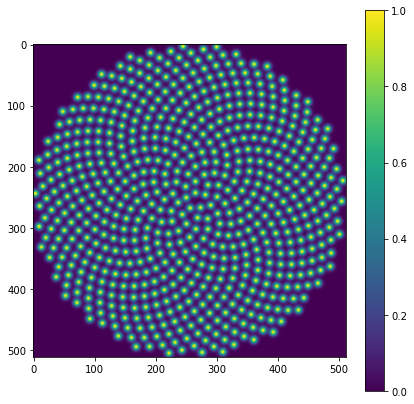

In [5]:
gwfr = Rayfront(wavelength=2.2e-6,size=5e-3,samplescheme='fibbonacci')
osys = GaubletOpticalSystem(epd=5e-3,dimd=5e-3,npix=512)
osys.add_aperture(shape='lyot',diameter=5e-3)
osys.add_distance(distance=0,index=1)
#osys.add_aperture(shape='fpm',diameter=2.5e-4)
osys.add_detector()
gwfr.propogate(elements=osys.elements)

# Set up figure
plt.figure(figsize=[7,7])
plt.imshow((np.abs(gwfr.Ephase)))
plt.colorbar()
plt.show()

# Lyot stop needs to be shifted on-axis
# it's the same index responsible for both lists (y >= 0, x >= 0)

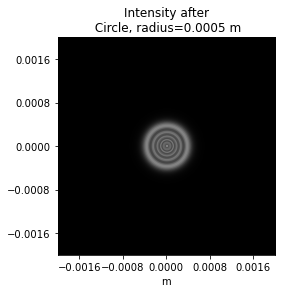

In [3]:
npix = 512
wf = poppy.FresnelWavefront(5e-4*u.m,wavelength=2200e-9,npix=npix,oversample=4)
wf *= poppy.CircularAperture(radius=5e-4)
wf.propagate_fresnel(1e-2)
wf.display(imagecrop=.05)

In [ ]:
N = 22.7272
print((0.05**2)/(N*2.2e-6))

In [ ]:
# paper figures
efl = 1
d = 1e-3#np.linspace(1,1e2,1000)
F = np.array([[1,0,0,0],
             [0,1,0,0],
              
             [-1/efl,0,1,0],
             [0,-1/efl,0,1]])

P = np.array([[1,0,1,d],
             [0,1,d,1],
             [0,0,1,0],
             [0,0,0,1]])

sys = np.matmul(P,F)

A = sys[0:2,0:2] # this has a tendency to be zero-valued at focus
B = sys[0:2,2:4]
C = sys[2:4,0:2]
D = sys[2:4,2:4]

x = np.linspace(-2e-5,2e-5,512)
y = x

x,y = np.meshgrid(x,y)

wo = 5*(2.2e-6)
zr = np.pi*wo**2.0/2.2e-6
        
Q = np.array([[1.0/(1j*zr),0],
              [0,1.0/(3j*zr)]],dtype='complex')

Qp = (C+np.matmul(D,Q))*np.linalg.inv(A+np.matmul(B,Q))

u = x*4000
v = y*4000

gaub = np.exp((-1j*(np.pi/2.2e-6))*(Q[0,0]*x**2 + (Q[1,0] + Q[0,1])*x*y + Q[1,1]*y**2))
gaup = np.exp((-1j*(np.pi/2.2e-6))*(Qp[0,0]*u**2 + (Qp[1,0] + Qp[0,1])*u*v + Qp[1,1]*v**2))


fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,(np.abs(gaub*np.conj(gaub))),cmap=cm.magma)
ax.view_init(45,135) # alt, az
plt.show()

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
ax.plot_surface(u,v,(np.abs(gaup*np.conj(gaup))),cmap=cm.magma)
ax.view_init(45,135) # alt, az
plt.show()